In [16]:
import optuna
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, \
                            f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pickle

In [17]:
# Muat data
with open("train_test_data.pkl", "rb") as f:
    data = pickle.load(f)
    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]

# Muat pipeline preprocessing (BELUM DI-FIT)
with open("preprocessing_pipeline.pkl", "rb") as f:
    preprocess = pickle.load(f) 

# Opsional: muat nama fitur
with open("feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

## Bangun Lasso

In [18]:
# ============================================================
# Membangun model Lasso
# ============================================================

seed=42
# Fungsi optimisasi Lasso dengan Optuna
def objective_lasso(trial):
    C = trial.suggest_float('C', 0.001, 0.1, log=True)
    model = LogisticRegression(penalty='l1', C=C, solver='saga', class_weight= 'balanced', max_iter=2000, random_state=seed)
    # Memasukkan preprocessing ke pipeline
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ('lasso', model)
    ])
    return cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()

# Optimize Lasso menggunakan Optuna
study_lasso = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study_lasso.optimize(objective_lasso, n_trials=50)

# Tampilkan hasil terbaik
best_C = study_lasso.best_params['C']
print("Best Lasso Params:", study_lasso.best_params)
print("Best AUC (CV):", study_lasso.best_value)

# Muat best_params yang sudah ada
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

# Tambahkan parameter Lasso
best_params["lasso"] = study_lasso.best_params

# Simpan ulang
with open("best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)
    
# Bangun model final dengan konfigurasi terbaik
best_lasso = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        penalty='l1',
        C=best_C,
        solver='saga',
        max_iter=2000,
        class_weight='balanced',
        random_state=seed
    ))
])

# Latih model final pada seluruh data pelatihan
best_lasso.fit(X_train, y_train)


[I 2026-01-19 23:23:25,419] A new study created in memory with name: no-name-a7b98a53-f54f-4902-8086-e359a3f8ab95
[I 2026-01-19 23:23:29,702] Trial 0 finished with value: 0.5 and parameters: {'C': 0.005611516415334507}. Best is trial 0 with value: 0.5.
[I 2026-01-19 23:23:32,843] Trial 1 finished with value: 0.6892086947986741 and parameters: {'C': 0.07969454818643935}. Best is trial 1 with value: 0.6892086947986741.
[I 2026-01-19 23:23:35,224] Trial 2 finished with value: 0.603709846202632 and parameters: {'C': 0.029106359131330698}. Best is trial 1 with value: 0.6892086947986741.
[I 2026-01-19 23:23:35,404] Trial 3 finished with value: 0.5042660611414378 and parameters: {'C': 0.015751320499779727}. Best is trial 1 with value: 0.6892086947986741.
[I 2026-01-19 23:23:35,544] Trial 4 finished with value: 0.5 and parameters: {'C': 0.0020513382630874496}. Best is trial 1 with value: 0.6892086947986741.
[I 2026-01-19 23:23:35,681] Trial 5 finished with value: 0.5 and parameters: {'C': 0.00

Best Lasso Params: {'C': 0.099727047381825}
Best AUC (CV): 0.7298758597778734


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('te', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains

In [19]:
def evaluate_cv_stability(model, X, y, cv, model_name="Model"):
    scores = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )

    mean_auc = scores.mean()
    std_auc = scores.std()

    print(f"{model_name}")
    print(f"ROC-AUC CV Mean : {mean_auc:.4f}")
    print(f"ROC-AUC CV Std  : {std_auc:.4f}")
    print("-" * 40)

    return mean_auc, std_auc


# Evaluasi Model

In [20]:
# ============================================================
# FUNGSI EVALUASI
# ============================================================
def evaluate_model_full(y_true, y_proba, name="Model"):
    roc_auc = roc_auc_score(y_true, y_proba)
    y_pred = (y_proba >= 0.5).astype(int)

    recall_fraud = recall_score(y_true, y_pred, pos_label=1)
    precision_fraud = precision_score(y_true, y_pred, pos_label=1)
    f1_fraud = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    print(f"=== {name} ===")
    print(f" ROC-AUC            : {roc_auc:.4f}")
    print(f" Accuracy           : {accuracy:.4f}")
    print(f" Precision (Fraud)  : {precision_fraud:.4f}")
    print(f" Recall (Fraud)     : {recall_fraud:.4f}")
    print(f" F1-Score (Fraud)   : {f1_fraud:.4f}")
    print(f" Specificity (Non-F): {specificity:.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 60)

In [21]:
# ============================================================
# EVALUASI: LASSO (data test)
# ============================================================

y_proba_lasso = best_lasso.predict_proba(X_test)[:, 1]

evaluate_model_full(y_test, y_proba_lasso,
                    "Baseline Lasso Logistic Regression")


=== Baseline Lasso Logistic Regression ===
 ROC-AUC            : 0.7124
 Accuracy           : 0.6867
 Precision (Fraud)  : 0.3958
 Recall (Fraud)     : 0.5135
 F1-Score (Fraud)   : 0.4471
 Specificity (Non-F): 0.7434
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       226
           1       0.40      0.51      0.45        74

    accuracy                           0.69       300
   macro avg       0.61      0.63      0.61       300
weighted avg       0.72      0.69      0.70       300

------------------------------------------------------------


In [22]:
# ============================================================
# EVALUASI: STACKING vs LASSO vs XGBoost (data train)
# ============================================================
y_proba_lasso_train = best_lasso.predict_proba(X_train)[:, 1]

evaluate_model_full(y_train, y_proba_lasso_train,
                    "Baseline Lasso Logistic Regression")

=== Baseline Lasso Logistic Regression ===
 ROC-AUC            : 0.8153
 Accuracy           : 0.7368
 Precision (Fraud)  : 0.4786
 Recall (Fraud)     : 0.7110
 F1-Score (Fraud)   : 0.5721
 Specificity (Non-F): 0.7452
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       526
           1       0.48      0.71      0.57       173

    accuracy                           0.74       699
   macro avg       0.68      0.73      0.69       699
weighted avg       0.79      0.74      0.75       699

------------------------------------------------------------


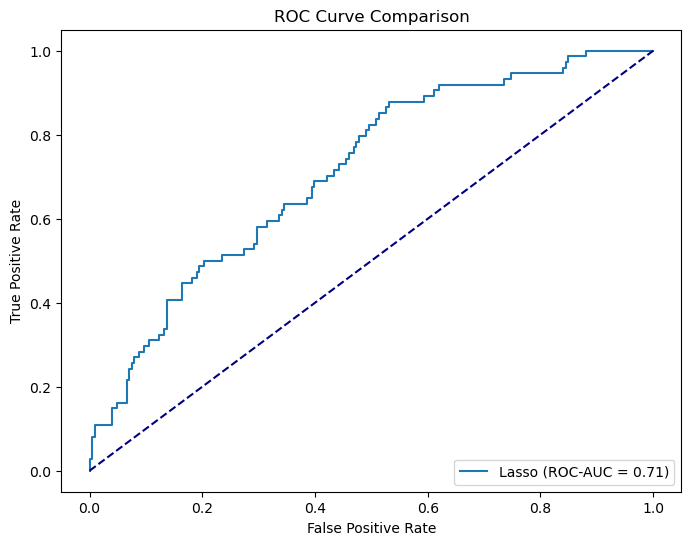

In [23]:
# Menghitung probabilitas untuk tiap model
y_proba_lasso = best_lasso.predict_proba(X_test)[:, 1]

# Menghitung ROC curve untuk tiap model
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_proba_lasso)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso, label='Lasso (ROC-AUC = %0.2f)' % roc_auc_score(y_test, y_proba_lasso))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


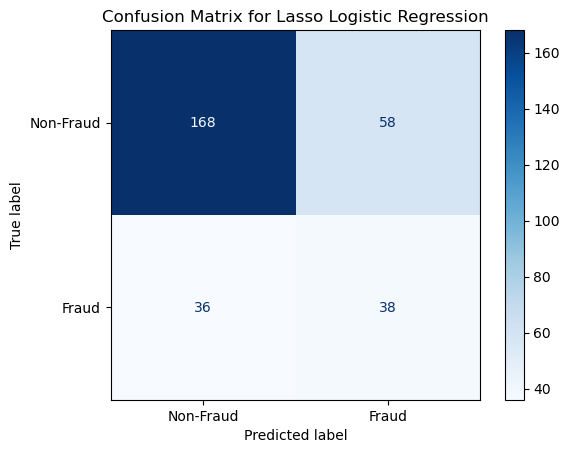

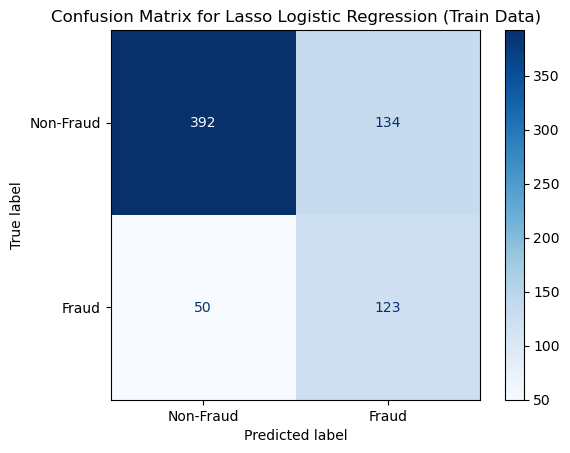

In [24]:
# Confusion Matrix untuk Lasso
cm_lasso = confusion_matrix(y_test, (y_proba_lasso >= 0.5).astype(int))
disp_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso, display_labels=["Non-Fraud", "Fraud"])
disp_lasso.plot(cmap="Blues")
plt.title("Confusion Matrix for Lasso Logistic Regression")
plt.show()

# Predict probabilities on training data
y_train_proba_lasso = best_lasso.predict_proba(X_train)[:, 1]

# Confusion Matrix for Lasso on training data
cm_train_lasso = confusion_matrix(y_train, (y_train_proba_lasso >= 0.5).astype(int))
disp_train_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_train_lasso, display_labels=["Non-Fraud", "Fraud"])
disp_train_lasso.plot(cmap="Blues")
plt.title("Confusion Matrix for Lasso Logistic Regression (Train Data)")
plt.show()

In [25]:
# Ambil koefisien dari model Lasso
coef = best_lasso.named_steps['clf'].coef_[0]  # karena binary classification, coef_ berbentuk (1, n_features)

# Pastikan jumlah fitur cocok
assert len(feature_names) == len(coef), f"Jumlah fitur tidak cocok: {len(feature_names)} vs {len(coef)}"

# Buat DataFrame koefisien
lasso_coeff = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})

# Menampilkan fitur dengan koefisien 0 (dihapus oleh Lasso)
lasso_coeff_zeros = lasso_coeff[lasso_coeff['coefficient'] == 0]
print("Fitur dengan koefisien 0 (dihapus oleh Lasso):")
print(lasso_coeff_zeros[['feature']])

# Menampilkan fitur yang dipertahankan (koefisien non-zero)
lasso_coeff_non_zero = lasso_coeff[lasso_coeff['coefficient'] != 0]
print("\nFitur yang dipertahankan oleh Lasso:")
print(lasso_coeff_non_zero.sort_values('coefficient', key=abs, ascending=False))

Fitur dengan koefisien 0 (dihapus oleh Lasso):
                                   feature
0                       months_as_customer
1                                      age
2                    policy_annual_premium
3                            capital-gains
4                             capital-loss
5                 incident_hour_of_the_day
6              number_of_vehicles_involved
7                          bodily_injuries
9                       total_claim_amount
10                            injury_claim
13                               auto_year
14                       days_since_policy
15            high_claim_without_witnesses
19                  unknown_collision_type
20                multi_vehicles_no_injury
21                              zip_prefix
22                         auto_make_model
24                      insured_occupation
28                       policy_deductable
30                         policy_state_IN
31                         policy_state_OH
32     

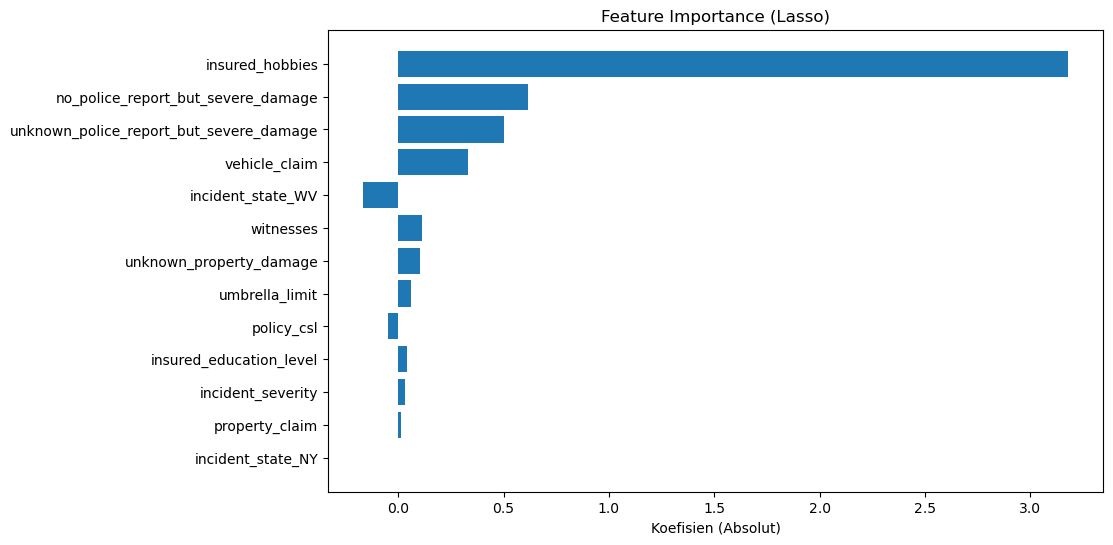

In [26]:
# Visualisasi feature importance di Lasso dengan koefisien absolut
plt.figure(figsize=(10, 6))
lasso_coeff_non_zero = lasso_coeff[lasso_coeff['coefficient'] != 0]
lasso_coeff_non_zero = lasso_coeff_non_zero.sort_values(by='coefficient', key=abs, ascending=False)

plt.barh(lasso_coeff_non_zero['feature'], lasso_coeff_non_zero['coefficient'])
plt.xlabel('Koefisien (Absolut)')
plt.title('Feature Importance (Lasso)')
plt.gca().invert_yaxis()  # Membalik agar fitur paling penting di atas
plt.show()


# info tambahan

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Lasso
lasso_mean, lasso_std = evaluate_cv_stability(
    best_lasso,
    X_train,
    y_train,
    cv,
    model_name="Lasso Logistic Regression"
)

Lasso Logistic Regression
ROC-AUC CV Mean : 0.7320
ROC-AUC CV Std  : 0.0131
----------------------------------------
